In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math, os
import glob
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from ipynb.fs.full.Arjuns_Implementation import get_ifft, get_time_domain_averagedDF, get_fft, get_wind_fft, get_batchWise_fft, get_newFFT_Data

warnings.filterwarnings("ignore")

In [3]:
walk_fft = pd.read_csv("C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\processed_data\\new_walk_jasmin.csv")
jog_fft = pd.read_csv("C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\processed_data\\new_jog_df.csv")
up_fft = pd.read_csv("C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\processed_data\\new_up_df.csv")

In [4]:
walk_clean_fft_df = get_newFFT_Data(walk_fft)
walk_clean_fft_df.to_csv("walk_merged_clean_fft.csv")

In [5]:
jog_clean_fft_df = get_newFFT_Data(jog_fft)
jog_clean_fft_df.to_csv("jog_merged_clean_fft.csv")

In [6]:
up_clean_fft_df = get_newFFT_Data(up_fft)
up_clean_fft_df.to_csv("up_merged_clean_fft.csv")

In [7]:
walk_clean_fft_df["batch"].value_counts()

batch
3      30
187    30
172    30
173    30
174    30
       ..
98     30
99     30
100    30
101    30
282    30
Name: count, Length: 233, dtype: int64

In [8]:
jog_clean_fft_df["batch"].value_counts()

batch
1      30
186    30
188    30
189    30
190    30
       ..
119    30
120    30
121    30
122    30
261    30
Name: count, Length: 198, dtype: int64

In [9]:
up_clean_fft_df["batch"].value_counts()

batch
2     30
3     30
8     30
9     30
10    30
11    30
12    30
21    30
22    30
32    30
33    30
34    30
35    30
Name: count, dtype: int64

In [17]:
up_clean_fft_df["CSI_AMP"][0]

array([8.76000000e+02, 3.60000000e+01, 1.75541673e-16, 1.11408128e-14,
       1.87671259e-14, 1.84762302e-14, 2.40831892e+01, 3.11448230e+01,
       3.75898923e+01, 3.60555128e+01, 4.60434577e+01, 3.41760150e+01,
       2.60192237e+01, 2.56320112e+01, 1.89736660e+01, 3.43656806e+01,
       2.02237484e+01, 3.23882695e+01, 2.56320112e+01, 2.45153013e+01,
       2.95296461e+01, 2.26715681e+01, 2.80178515e+01, 2.99666481e+01,
       2.00249844e+01, 2.24722051e+01, 2.06155281e+01, 1.11803399e+01,
       2.34093998e+01, 1.89736660e+01, 2.60192237e+01, 3.40587727e+01,
       1.23194604e-14, 1.33416641e+01, 2.78926514e+01, 2.23606798e+01,
       2.22036033e+01, 2.78926514e+01, 1.86010752e+01, 2.19317122e+01,
       1.41421356e+01, 1.74642492e+01, 1.60312195e+01, 2.80178515e+01,
       8.06225775e+00, 2.10237960e+01, 1.98494332e+01, 1.61245155e+01,
       3.35261092e+01, 2.12132034e+01, 1.20415946e+01, 1.70000000e+01,
       2.26274170e+01, 2.05912603e+01, 2.36008474e+01, 2.64007576e+01,
      

In [28]:
def spilt_amplitude_from_FFT(activity_df_fft):
    csi_rows_raw = []
    for one_row in activity_df_fft["CSI_AMP"]:
        # one_row = one_row.strip("[]")
        # csi_row_raw = [float(x) for x in one_row.split(" ") if x != '']
        csi_row_raw = [float(x) for x in one_row if x != '']
        csi_rows_raw.append(csi_row_raw)

    # Convert the list of lists to a DataFrame and append it to the appropriate DataFrame based on the file name
    csi_df = pd.DataFrame(csi_rows_raw)
    csi_df["batch"]=activity_df_fft["batch"]
    return csi_df

In [29]:
final_walk_df = spilt_amplitude_from_FFT(walk_clean_fft_df)
final_jog_df = spilt_amplitude_from_FFT(jog_clean_fft_df)
final_up_df = spilt_amplitude_from_FFT(up_clean_fft_df)

In [30]:
final_up_df.shape

(390, 65)

### Scale the data

In [31]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_data = scaler.transform(df)
    return scaled_data

scaled_walk_df = perform_scaling(final_walk_df.iloc[:,4:60])
walk_scaled_df = pd.DataFrame(scaled_walk_df)
walk_scaled_df["batch"] = final_walk_df["batch"]

scaled_up_df = perform_scaling(final_up_df.iloc[:,4:60])
up_scaled_df = pd.DataFrame(scaled_up_df)
up_scaled_df["batch"] = final_up_df["batch"]

scaled_jog_df = perform_scaling(final_jog_df.iloc[:,4:60])
jog_scaled_df = pd.DataFrame(scaled_jog_df)
jog_scaled_df["batch"] = final_jog_df["batch"]

In [32]:
walk_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,batch
0,2.627294,1.018628,1.030851,2.319299,2.056027,1.773338,1.371029,1.038874,1.236069,1.191990,...,1.293160,0.378810,2.339457,0.020614,1.265603,1.035481,1.317624,1.917175,0.644366,3
1,-1.589635,-1.926877,-1.033768,-1.126245,-1.145461,-0.963836,-0.939524,-1.079448,-1.425030,-0.511007,...,-0.877911,-0.458067,-0.450746,-0.524239,-0.566098,-0.561083,-0.550260,-0.376234,-0.982874,3
2,-1.224333,-1.438570,-0.767657,-0.279731,-0.868325,-0.508416,-0.737686,-0.669737,-0.459546,-0.928216,...,-0.324862,-0.651447,-0.598407,-0.460832,-0.281140,-0.590519,0.182855,-0.153743,-0.714831,3
3,-1.256859,-0.946946,-0.754931,-1.006398,-1.041451,-0.889598,-1.239742,-1.172049,-0.507408,-1.302262,...,-0.693477,-0.535113,0.280975,-0.413443,-0.586614,-0.435471,0.301769,-0.570434,-0.103996,3
4,0.257691,-0.484151,-0.076765,-1.006398,-0.382896,0.197582,-0.299992,0.616240,0.098577,-0.491347,...,0.850854,0.588257,-0.598407,0.128805,0.639780,1.445124,0.139727,0.697363,-0.352153,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6985,-0.364494,-0.602884,-0.511178,-0.100962,-0.463255,0.063634,-0.045515,0.101474,0.174857,-0.566335,...,0.448026,0.321174,0.071941,0.839724,0.022999,0.270421,0.287934,0.200921,-1.074048,282
6986,1.241710,1.340601,-1.285434,-1.417960,-0.699235,-1.043394,-1.279830,-1.406088,-1.222601,-1.101182,...,-0.753677,-0.154793,-0.347592,-0.671206,-0.116894,-0.359609,-0.928924,-1.139059,-0.217409,282
6987,0.023530,-0.611872,1.022039,0.494254,1.016914,0.568906,0.580190,0.157536,0.360230,0.194636,...,1.249403,1.971588,0.785225,1.219885,1.314192,1.513637,0.156862,1.197103,-1.268225,282
6988,-0.004997,-0.579524,-0.787044,-1.244583,-1.372086,-0.997228,-0.600394,-1.115939,-0.625988,-0.984597,...,-0.687425,0.199724,0.217367,0.417477,0.557079,-0.249854,-0.306092,0.333085,0.123966,282


### Flatten the scaled data

In [33]:
def flatten_dataframe(scaled_Dataframe):
    flattened_data = []
    for batch in scaled_Dataframe["batch"].unique():
        batch_data = scaled_Dataframe[scaled_Dataframe["batch"]==batch].drop(columns = ["batch"]).values.flatten()    
        flattened_data.append(batch_data)
    return flattened_data

walk_flat_data = flatten_dataframe(walk_scaled_df)
print(np.array(walk_flat_data).shape)

jog_flat_data = flatten_dataframe(jog_scaled_df)
print(np.array(jog_flat_data).shape)

up_flat_data = flatten_dataframe(up_scaled_df)
print(np.array(up_flat_data).shape)

(233, 1680)
(198, 1680)
(13, 1680)


### PCA of the scaled data

In [34]:
def perform_pca(X, n_components):
    """
    Perform PCA on the data.
    """
    pca = PCA(n_components=n_components)
    pca.fit(X)
    new_sample = pca.transform(X)
    return pca, new_sample

N_COMPONENTS = 5
pca_obj_walk, pca_walk_data = perform_pca(walk_flat_data, N_COMPONENTS)
pca_obj_jog, pca_jog_data = perform_pca(jog_flat_data, N_COMPONENTS)
pca_obj_up, pca_up_data = perform_pca(up_flat_data, N_COMPONENTS)

### Visualization of the processed data

In [41]:
## Select and plot raw scaled samples
def raw_sample_plot(raw_sample, activity):
    # raw_sample =  pd.DataFrame(np.vstack(downsampled))
    # print(raw_sample)
    plt.figure(figsize = (14,10))

    ax1 = plt.subplot(611)
    # plt.plot(raw_sample.iloc[:,0],'r')
    # plt.plot(raw_sample.iloc[:,1],'g')
    # plt.plot(raw_sample.iloc[:,2],'b')
    # plt.plot(raw_sample.iloc[:,3],'cyan')
    # plt.plot(raw_sample.iloc[:,4],'brown')
    # plt.plot(raw_sample.iloc[:,5],'lightgreen')
    plt.plot(raw_sample.iloc[:,6],'aqua')
    # plt.plot(raw_sample.iloc[:,7],'lime')
    # plt.plot(raw_sample.iloc[:,8],'orchid')
    # plt.plot(raw_sample.iloc[:,9],'navy')
    # plt.plot(raw_sample.iloc[:,10],'royalblue')
    # plt.plot(raw_sample.iloc[:,11],'peru')
    # plt.plot(raw_sample.iloc[:,12],'tan')
    plt.ylabel("Amplitude")
    ax1.set_title(f"Amplitude of subcarrier 6 to 18 while {activity}")

    ax2 = plt.subplot(612)
    plt.plot(raw_sample.iloc[:,13],'r')
    plt.plot(raw_sample.iloc[:,14],'g')
    plt.plot(raw_sample.iloc[:,15],'b')
    plt.plot(raw_sample.iloc[:,16],'cyan')
    plt.plot(raw_sample.iloc[:,17],'brown')
    plt.plot(raw_sample.iloc[:,18],'lightgreen')
    plt.plot(raw_sample.iloc[:,19],'aqua')
    plt.plot(raw_sample.iloc[:,20],'lime')
    plt.plot(raw_sample.iloc[:,21],'orchid')
    plt.plot(raw_sample.iloc[:,22],'navy')
    plt.plot(raw_sample.iloc[:,23],'royalblue')
    plt.plot(raw_sample.iloc[:,24],'peru')
    plt.plot(raw_sample.iloc[:,25],'tan')
    plt.ylabel("Amplitude")
    ax2.set_title(f"Amplitude of subcarrier 19 to 31 while {activity}")

    ax3 = plt.subplot(613)
    plt.plot(raw_sample.iloc[:,26],'r')
    plt.plot(raw_sample.iloc[:,27],'g')
    plt.plot(raw_sample.iloc[:,28],'b')
    plt.plot(raw_sample.iloc[:,29],'cyan')
    plt.plot(raw_sample.iloc[:,30],'brown')
    plt.plot(raw_sample.iloc[:,31],'lightgreen')
    plt.plot(raw_sample.iloc[:,32],'aqua')
    plt.plot(raw_sample.iloc[:,33],'lime')
    plt.plot(raw_sample.iloc[:,34],'orchid')
    plt.plot(raw_sample.iloc[:,35],'navy')
    plt.plot(raw_sample.iloc[:,36],'royalblue')
    plt.plot(raw_sample.iloc[:,37],'peru')
    plt.plot(raw_sample.iloc[:,38],'tan')
    plt.ylabel("Amplitude")
    ax3.set_title(f"Amplitude of subcarrier 33 to 46 while {activity}")

    ax4 = plt.subplot(614)
    plt.plot(raw_sample.iloc[:,39],'r')
    plt.plot(raw_sample.iloc[:,40],'g')
    plt.plot(raw_sample.iloc[:,41],'b')
    plt.plot(raw_sample.iloc[:,42],'cyan')
    plt.plot(raw_sample.iloc[:,43],'brown')
    plt.plot(raw_sample.iloc[:,44],'lightgreen')
    plt.plot(raw_sample.iloc[:,45],'aqua')
    plt.plot(raw_sample.iloc[:,46],'lime')
    plt.plot(raw_sample.iloc[:,47],'orchid')
    plt.plot(raw_sample.iloc[:,48],'navy')
    plt.plot(raw_sample.iloc[:,49],'royalblue')
    plt.plot(raw_sample.iloc[:,50],'peru')
    plt.plot(raw_sample.iloc[:,51],'tan')
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    ax4.set_title(f"Amplitude of subcarrier 47 to 58 while {activity}")

    plt.subplots_adjust(hspace=0.6)
    plt.show()

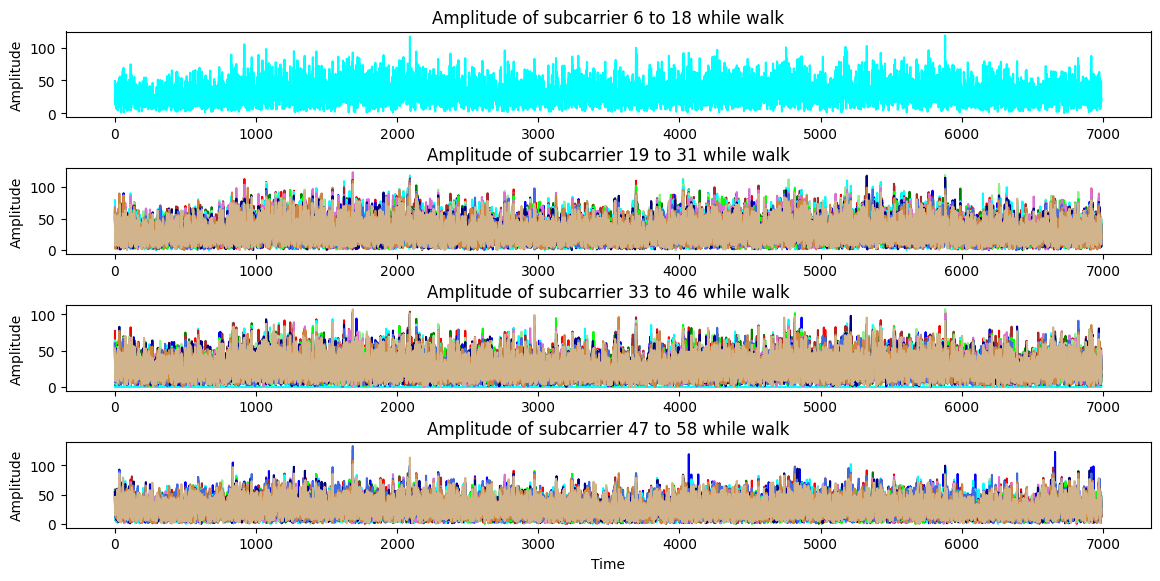

In [42]:
raw_sample_plot(final_walk_df,'walk')

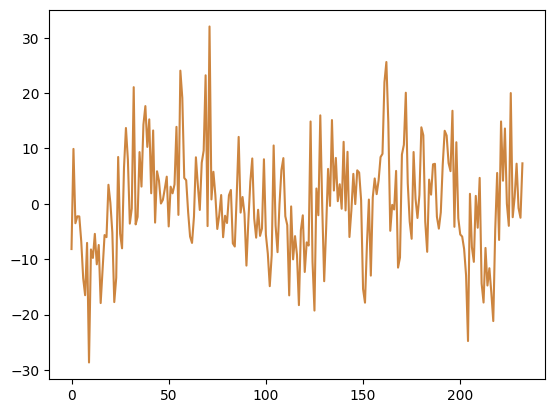

In [49]:

pca_walk_df = pd.DataFrame(pca_walk_data)
plt.plot(pca_walk_df.iloc[:,0],'peru')
# plt.plot(pca_walk_df.iloc[:,1],'lime')
# plt.plot(pca_walk_df.iloc[:,2],'orchid')
# plt.plot(pca_walk_df.iloc[:,3],'navy')
# plt.plot(pca_walk_df.iloc[:,4],'royalblue')

In [51]:
pca_walk_df = pd.DataFrame(pca_walk_data)
pca_walk_df['label'] = 0
pca_jog_df = pd.DataFrame(pca_jog_data)
pca_jog_df['label'] = 1
pca_up_df = pd.DataFrame(pca_up_data)
pca_up_df['label']=2

training_df = pd.concat([pca_walk_df,pca_jog_df,pca_up_df],axis=0)
training_df

,0,1,2,3,4,label
0,-8.169235,-2.027206,-6.303571,4.311167,-3.852374,0
1,9.917594,16.070296,-3.233547,-8.468074,9.554725,0
2,-3.503321,-0.476571,-5.830285,-1.335542,-4.719652,0
3,-2.250063,4.023868,-1.729383,-1.177607,-4.525349,0
4,-2.277398,-0.629237,-11.871893,-1.476167,-14.112234,0
...,...,...,...,...,...,...
8,-8.203480,-7.882455,12.858162,-17.424913,-6.843420,2
9,12.355292,14.572841,-19.291945,-17.322523,3.169009,2
10,19.707533,18.361879,28.008004,11.848742,-1.838929,2
11,3.818781,-7.110589,3.874800,-15.043283,-21.704150,2


### Data Spliting for Model


In [81]:
pca_walk_df = pd.DataFrame(walk_flat_data)
pca_walk_df['label'] = 0
pca_jog_df = pd.DataFrame(jog_flat_data)
pca_jog_df['label'] = 1
pca_up_df = pd.DataFrame(up_flat_data)
pca_up_df['label']=2

training_df = pd.concat([pca_walk_df,pca_jog_df,pca_up_df],axis=0)
training_df

,0,1,2,3,4,5,6,7,8,9,...,1671,1672,1673,1674,1675,1676,1677,1678,1679,label
0,2.627294,1.018628,1.030851,2.319299,2.056027,1.773338,1.371029,1.038874,1.236069,1.191990,...,-1.461491,-1.466892,-0.926617,-1.201470,-1.002472,-0.919460,-0.941420,-1.014308,-1.128168,0
1,0.046583,0.186704,-0.940461,-0.941082,-0.028167,-0.936712,-0.191638,-0.656994,-0.403093,-0.061000,...,-1.121846,-1.504646,-0.452392,-0.426822,-0.330416,-0.407697,-0.993231,-0.630052,0.546273,0
2,-0.234941,-0.196728,-0.238177,0.157090,-0.616330,0.285345,-0.156773,0.843667,0.330561,0.083885,...,-1.325389,-1.664576,-1.569681,-1.300815,-0.927512,-1.064096,-1.656356,-1.550145,-0.830843,0
3,2.891425,1.622432,0.877121,0.237322,0.319749,-0.051536,0.098582,0.720344,0.215484,1.083387,...,-1.325389,-0.954395,-1.753467,-0.943824,-0.091004,-1.157252,-1.077457,-0.889062,-0.976517,0
4,1.457091,0.959100,1.547005,0.952709,0.159056,0.512096,0.718803,0.356179,0.758721,2.125510,...,0.279160,0.743346,1.035412,0.061118,0.029342,-0.520646,0.714989,-0.744333,1.757584,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,-2.024733,-2.510408,-0.722586,-1.085986,-0.945242,-1.002110,-1.205564,-0.841831,-1.302749,-0.752285,...,-0.242377,-1.170391,-0.952149,0.016294,-1.257808,-0.887852,-0.984725,-0.885073,-1.242265,2
9,-0.862645,-1.364505,-1.307255,-1.028051,-1.620741,-0.759258,-1.098355,-0.590975,-1.492946,-1.328345,...,0.331345,-0.151531,-1.327412,0.290666,0.656954,0.715077,0.018158,-0.395785,-0.366307,2
10,-0.284597,-0.978833,-0.559045,-0.706392,-0.527005,-0.648278,-0.237823,-0.963455,-0.712053,-0.716931,...,-1.253417,-1.563108,-1.149968,-1.346614,-1.451545,-1.245708,-1.561144,-1.008152,0.317929,2
11,-0.808088,-0.324195,-0.066947,-0.439909,-0.484482,-0.638334,-0.614869,-0.399470,-0.607591,-0.505128,...,-1.067900,-1.259264,-0.614381,-0.930540,-1.060540,-1.406087,-0.657918,-1.061192,-0.504206,2


In [82]:
from sklearn.model_selection import train_test_split

def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state,stratify=y)
    return X_train, X_test, y_train, y_test

In [83]:
X_train, X_test, y_train, y_test = train_test_split_data(training_df.drop(columns=['label']),training_df['label'])

In [84]:
def train_svm(X_train, y_train):
    """
    Train SVM model using the training data.
    """
    svm = SVC()
    svm.fit(X_train, y_train)
    return svm


def train_knn(X_train, y_train):
    """
    Train KNN model using the training data.
    """
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn

def train_model(model_type, X_train, y_train):
    """
    Train model of given type using the training data.
    """
    if model_type == 'svm':
        model = train_svm(X_train, y_train)
    elif model_type == 'knn':
        model = train_knn(X_train, y_train)
    # elif model_type == 'cnn':
    #     model = train_cnn(X_train, y_train)
    # elif model_type == 'lstm':
    #     model = train_lstm(X_train, y_train)
    else:
        raise ValueError('Invalid model type.')
    return model


def test_model(model, X_test):
    """
    Evaluate the trained model on the testing data.
    """ 
    label = model.predict(X_test)
    return label

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the testing data.
    """ 
    score = model.score(X_test, y_test)
    return score



In [85]:
svm = train_model('svm', X_train, y_train)
y_pred = test_model(svm, X_test)
print(evaluate_model(svm, X_test, y_test))
confusion_matrix(y_test, y_pred)

0.5617977528089888


array([[36, 11,  0],
       [26, 14,  0],
       [ 1,  1,  0]], dtype=int64)